# LangGraph
a new and powerful tool within LangChain for building structured workflows and control flows for LLM-based systems.

LangGraph lets you represent logic like this:


START → (Node 1) → (Node 2) → ... → END


Instead of chaining models linearly (like a normal pipeline), you can define nodes (functions) and edges (connections) — forming a graph of possible flows.

It’s like defining a flowchart in code — and you can even visualize it

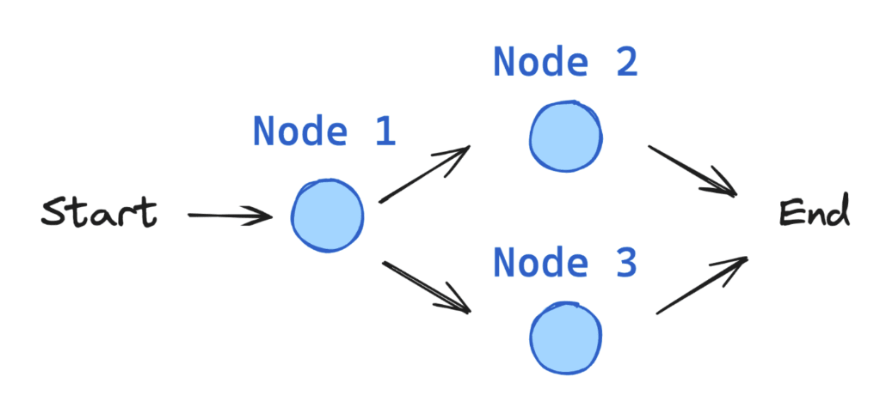

LangGraph (part of LangChain) allows you to build graph-based workflows — where each step in your logic is represented as a node, and the relationships between steps are defined as edges.

This is very powerful when building multi-step or branching AI systems — chatbots, agents, RAG pipelines, etc.

### Build a Simple Workflow or Graph Using LangGraph

#### State :
Every LangGraph starts with a State — a Python dictionary that defines what data each node receives and can modify.

First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

In [ ]:
from typing_extensions import TypedDict
class State(TypedDict):
    graph_info:str

* State defines the schema (keys and their types) for all the data that can flow through the graph.

* It’s a shared memory structure that moves between nodes.

* Each node receives the current State and returns an updated one.

#### Nodes
Nodes are just python functions.

Each node:
* Accepts the state (a dictionary matching your State schema)
* Performs some logic (e.g., modify text, call an LLM, make an API request)
* Returns a dictionary containing updated keys in the state

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [8]:
def start_play(state:State):
    print("Start_Play node has been called")
    return {"graph_info":state['graph_info'] + " I am planning to play"}

def cricket(state:State):
    print("My Cricket node has been called")
    return {"graph_info":state['graph_info'] + " Cricket"}

def badminton(state:State):
    print("My badminton node has been called")
    return {"graph_info":state['graph_info'] + " Badminton"}

When a node returns a dictionary like {"graph_info": "new value"},
LangGraph merges that result into the global state.

Keys with the same name are overwritten with the new value.

So the state evolves as it moves from node to node.

In [ ]:
import random
from typing import Literal

#This node decides — based on random chance — which branch to follow next
#Literal ->returns one of those exact strings
def random_play(state:State)-> Literal['cricket','badminton']:
    graph_info=state['graph_info']

    if random.random()>0.5:
        return "cricket"
    else:
        return "badminton"

## Edges: The Connections Between Nodes

Edges define the flow of execution — they tell LangGraph which node runs next after another finishes.

You can think of edges as arrows between boxes (nodes) in a flowchart.

LangGraph supports:
* Static edges → fixed connections
* Conditional edges →  allow you to introduce decision logic  - dynamic branching based on logic

#### Graph Construction: 
how all these nodes connect???

Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

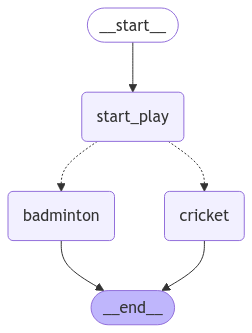

In [ ]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

## Build Graph
# Creates a new graph whose state schema is State.
# This means every node will receive and update graph_info.
graph=StateGraph(State)

## Adding the nodes
# Adds the functions as named nodes to the graph.
graph.add_node("start_play",start_play)
graph.add_node("cricket",cricket)
graph.add_node("badminton",badminton)

## Schedule the flow of the graph

graph.add_edge(START,"start_play")
graph.add_conditional_edges("start_play",random_play)
graph.add_edge("cricket",END)
graph.add_edge("badminton",END)

'''After start_play, LangGraph will call the function random_play() to determine which path to take.
Since random_play() returns either "cricket" or "badminton",
the graph routes execution to the corresponding node automatically.'''


## Compile the graph
graph_builder=graph.compile()

'''Compiles the graph for execution.
LangGraph checks for:
-Missing edges
-Circular dependencies
-Invalid transitions

Produces a runnable graph object that you can invoke.'''

## View
display(Image(graph_builder.get_graph().draw_mermaid_png()))

### GRAPH Invocation

In [ ]:
graph_builder.invoke({"graph_info":"Hey My name is Jhon"})

Start_Play node has been called
My badminton node has been called


{'graph_info': 'Hey My name is Krish I am planning to play Badminton'}

Execution Flow:
1. Input State → {"graph_info": "Hey My name is Krish"}
2. START → moves to start_play
3. start_play executes:
 </br>graph_info = "Hey My name is Krish I am planning to play"
4. Calls random_play() → returns either "cricket" or "badminton"
5. Runs that branch node, e.g.:
 </br>graph_info = "Hey My name is Krish I am planning to play Cricket"
6. Reaches END node → graph terminates


| Component                            | Type               | Purpose                                    |
| ------------------------------------ | ------------------ | ------------------------------------------ |
| `State`                              | TypedDict          | Shared data schema between nodes           |
| `start_play`, `cricket`, `badminton` | Node functions     | Define operations or steps                 |
| `random_play`                        | Conditional router | Decides which path to follow               |
| `StateGraph`                         | Graph class        | Container for all nodes and edges          |
| `START` / `END`                      | Special nodes      | Define entry and exit points               |
| `add_edge`                           | Method             | Connects nodes sequentially                |
| `add_conditional_edges`              | Method             | Adds branching logic                       |
| `compile()`                          | Method             | Validates and prepares graph for execution |
| `invoke()`                           | Method             | Runs the graph with given state            |
| `draw_mermaid_png()`                 | Method             | Visualizes graph structure                 |


Nodes let you modularize logic (each node = one step, one idea).

Edges let you control the flow of logic — sequential, conditional, or looping.

Graphs give you flexibility and structure: you can model dynamic LLM workflows, decision trees, or agent systems cleanly.